/Users/justinchang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Mask nifti image (3D) is located at: /Users/justinchang/nilearn_data/haxby2001/mask.nii.gz
Functional nifti image (4D) is located at: /Users/justinchang/nilearn_data/haxby2001/subj2/bold.nii.gz
['face' 'house']


/Users/justinchang/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Classification accuracy: 0.9630 / Chance level: 0.500000


/Users/justinchang/.local/lib/python3.6/site-packages/nilearn/plotting/__init__.py:20: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/justinchang/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/justinchang/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/justinchang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/justinchang/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/justinchang/anaconda3/lib/python3.6/site-packages/ipyk

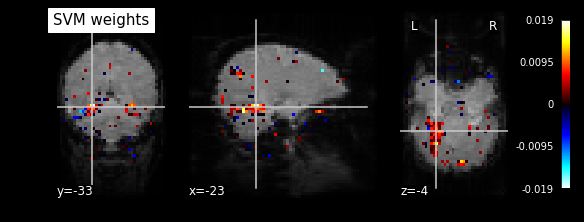

In [1]:
%matplotlib inline
"""
Decoding with ANOVA + SVM: face vs house in the Haxby dataset
===============================================================

This example does a simple but efficient decoding on the Haxby dataset:
using a feature selection, followed by an SVM.

"""

#############################################################################
# Retrieve the files of the Haxby dataset
# ----------------------------------------
from nilearn import datasets

# By default 2nd subject will be fetched
haxby_dataset = datasets.fetch_haxby()

# print basic information on the dataset
print('Mask nifti image (3D) is located at: %s' % haxby_dataset.mask)
print('Functional nifti image (4D) is located at: %s' %
      haxby_dataset.func[0])

#############################################################################
# Load the behavioral data
# -------------------------
import pandas as pd

# Load target information as string and give a numerical identifier to each
behavioral = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = behavioral['labels']

# Restrict the analysis to faces and places
condition_mask = behavioral['labels'].isin(['face', 'house'])
conditions = conditions[condition_mask]

# We now have 2 conditions
print(conditions.unique())
session = behavioral[condition_mask]

#############################################################################
# Prepare the fMRI data: smooth and apply the mask
# -------------------------------------------------
from nilearn.input_data import NiftiMasker

mask_filename = haxby_dataset.mask

# For decoding, standardizing is often very important
# note that we are also smoothing the data
masker = NiftiMasker(mask_img=mask_filename, smoothing_fwhm=4,
                     standardize=True, memory="nilearn_cache", memory_level=1)
func_filename = haxby_dataset.func[0]
X = masker.fit_transform(func_filename)
# Apply our condition_mask
X = X[condition_mask]

#############################################################################
# Build the decoder
# ------------------
# Define the prediction function to be used.
# Here we use a Support Vector Classification, with a linear kernel
from sklearn.svm import SVC
svc = SVC(kernel='linear')

# Define the dimension reduction to be used.
# Here we use a classical univariate feature selection based on F-test,
# namely Anova. When doing full-brain analysis, it is better to use
# SelectPercentile, keeping 5% of voxels
# (because it is independent of the resolution of the data).
from sklearn.feature_selection import SelectPercentile, f_classif
feature_selection = SelectPercentile(f_classif, percentile=5)

# We have our classifier (SVC), our feature selection (SelectPercentile),and now,
# we can plug them together in a *pipeline* that performs the two operations
# successively:
from sklearn.pipeline import Pipeline
anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])

#############################################################################
# Fit the decoder and predict
# ----------------------------
anova_svc.fit(X, conditions)
y_pred = anova_svc.predict(X)

#############################################################################
# Obtain prediction scores via cross validation
# -----------------------------------------------
from sklearn.cross_validation import LeaveOneLabelOut, cross_val_score

# Define the cross-validation scheme used for validation.
# Here we use a LeaveOneLabelOut cross-validation on the session label
# which corresponds to a leave-one-session-out
cv = LeaveOneLabelOut(session['chunks'])

# Compute the prediction accuracy for the different folds (i.e. session)
cv_scores = cross_val_score(anova_svc, X, conditions, cv=cv)

# Return the corresponding mean prediction accuracy
classification_accuracy = cv_scores.mean()

# Print the results
print("Classification accuracy: %.4f / Chance level: %f" %
      (classification_accuracy, 1. / len(conditions.unique())))
# Classification accuracy:  0.70370 / Chance level: 0.5000


#############################################################################
# Visualize the results
# ----------------------
# Look at the SVC's discriminating weights
coef = svc.coef_
# reverse feature selection
coef = feature_selection.inverse_transform(coef)
# reverse masking
weight_img = masker.inverse_transform(coef)


# Use the mean image as a background to avoid relying on anatomical data
from nilearn import image
mean_img = image.mean_img(func_filename)

# Create the figure
from nilearn.plotting import plot_stat_map, show
plot_stat_map(weight_img, mean_img, title='SVM weights')

# Saving the results as a Nifti file may also be important
weight_img.to_filename('example.nii')


show()
